#Assignment 4 : Named Entity Recognition using a Transformer-based model
##<b>Name: </b>Gopi Trinadh Maddikunta
##<b>PSID: </b><i>2409404</i>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json
import torch
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import torch.nn as nn
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertModel

In [3]:
# Load JSON data
with open('/content/drive/MyDrive/nlp/assignment4_data.json', 'r') as f:
    data = json.load(f)['annotations']

##Step1: Pre-processing

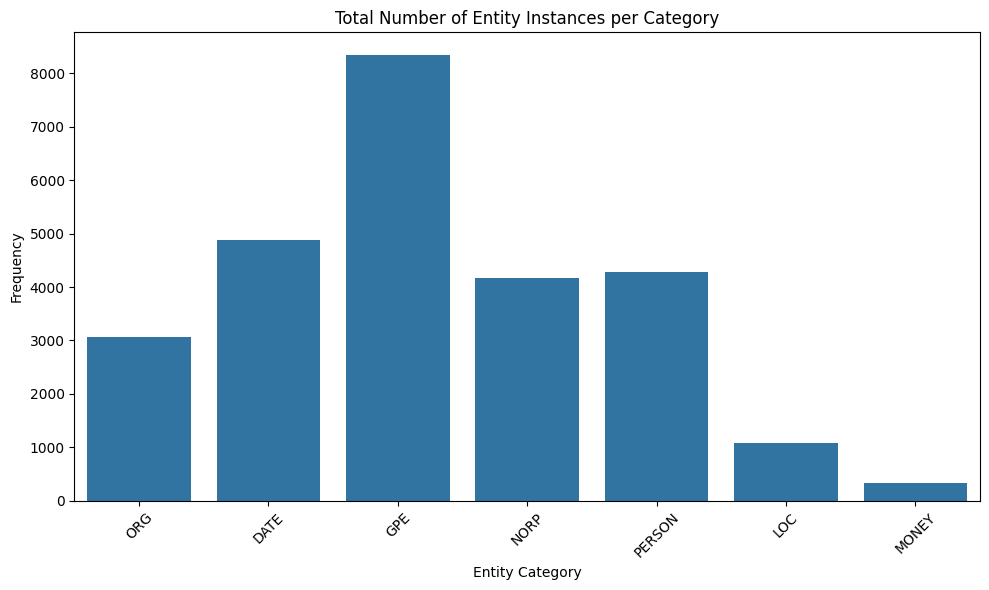

In [4]:
# Count entity instances and track tag presence per tweet
entity_counter = Counter()
tweet_tag_presence = defaultdict(set)

for i, (text, annotation) in enumerate(data):
    for start, end, label in annotation['entities']:
        clean_label = label.strip().upper()
        entity_counter[clean_label] += 1
        tweet_tag_presence[i].add(clean_label)

# Plot total number of instances per tag
plt.figure(figsize=(10, 6))
sns.barplot(x=list(entity_counter.keys()), y=list(entity_counter.values()))
plt.title('Total Number of Entity Instances per Category')
plt.ylabel('Frequency')
plt.xlabel('Entity Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
# Calculate tweet-level tag presence
total_tweets = len(data)
tag_tweet_distribution = {tag: 0 for tag in entity_counter.keys()}
two_or_more_tags = 0

for tags in tweet_tag_presence.values():
    for tag in tags:
        tag_tweet_distribution[tag] += 1
    if len(tags) >= 2:
        two_or_more_tags += 1

#Convert counts to percentages
tag_percentages = {tag: (count / total_tweets) * 100 for tag, count in tag_tweet_distribution.items()}
two_or_more_percentage = (two_or_more_tags / total_tweets) * 100

#Display tag statistics
print("Percentage of tweets that include at least one tag from each category:")
for tag, perc in tag_percentages.items():
    print(f"{tag}: {perc:.2f}%")

print(f"\nPercentage of tweets that include 2 or more distinct entity types: {two_or_more_percentage:.2f}%")


Percentage of tweets that include at least one tag from each category:
ORG: 23.02%
DATE: 37.35%
GPE: 49.86%
NORP: 28.64%
PERSON: 30.20%
LOC: 8.63%
MONEY: 2.59%

Percentage of tweets that include 2 or more distinct entity types: 58.72%


##Step 2: Converting to IOB tags

In [6]:
# Load DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

In [7]:
# Function 1: char_spans_to_iob
def char_spans_to_iob(text, entities):
    # Create a character-level map of entity labels
    char_map = {}
    for start, end, label in entities:
        label = label.strip().upper()
        for i in range(start, end):
            char_map[i] = label

    # Tokenize with offset mapping
    encoding = tokenizer(text, return_offsets_mapping=True, truncation=True)
    offsets = encoding['offset_mapping']
    tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'])

    iob_tags = []
    prev_label = None

    for idx, (start, end) in enumerate(offsets):
        if start == end:
            # [CLS], [SEP], or padding
            iob_tags.append("O")
            continue

        # Find unique entity tags in this token's character span
        tag_chars = [char_map.get(i) for i in range(start, end)]
        tag_chars = list(set(filter(None, tag_chars)))  # Remove None

        if not tag_chars:
            iob_tags.append("O")
            prev_label = None
        else:
            label = tag_chars[0]  # If multiple, pick one (first)
            if label != prev_label:
                iob_tags.append(f"B-{label}")
            else:
                iob_tags.append(f"I-{label}")
            prev_label = label

    return tokens, iob_tags

In [8]:
#Example usage
text = "Elon Musk met the UN officials in Geneva on June 5th."
entities = [
    [0, 9, "PERSON"],
    [18, 20, "ORG"],
    [38, 44, "GPE"],
    [48, 58, "DATE"]
]

tokens, iob_tags = char_spans_to_iob(text, entities)

print("Tokenized Output with IOB Tags:")
for token, tag in zip(tokens, iob_tags):
    print(f"{token:15} {tag}")


Tokenized Output with IOB Tags:
[CLS]           O
El              B-PERSON
##on            I-PERSON
Mu              I-PERSON
##sk            I-PERSON
met             O
the             O
UN              B-ORG
officials       O
in              O
Geneva          B-GPE
on              I-GPE
June            O
5th             B-DATE
.               I-DATE
[SEP]           O


##Step 3: Finetuning DistilBERT - Training a sequence labeling model:

In [9]:
# Define IOB tag mappings (15 classes)
entity_types = ['PERSON', 'NORP', 'ORG', 'GPE', 'LOC', 'DATE', 'MONEY']
iob_tags = ['O'] + [f'{prefix}-{tag}' for tag in entity_types for prefix in ['B', 'I']]
tag2id = {tag: i for i, tag in enumerate(iob_tags)}
id2tag = {i: tag for tag, i in tag2id.items()}

# Function from Phase 2 (assumed you already have it)
def char_spans_to_iob(text, entities):
    char_map = {}
    for start, end, label in entities:
        for i in range(start, end):
            char_map[i] = label.strip().upper()

    encoding = tokenizer(text, return_offsets_mapping=True, truncation=True, padding='max_length', max_length=128)
    offsets = encoding['offset_mapping']
    tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'])
    iob_tags_out = []
    prev_tag = None

    for start, end in offsets:
        if start == end:
            iob_tags_out.append("O")
            continue
        span = list(set([char_map.get(i, None) for i in range(start, end)]))
        span = list(filter(None, span))
        if not span:
            iob_tags_out.append("O")
            prev_tag = None
        else:
            tag = span[0]
            if prev_tag != tag:
                iob_tags_out.append(f"B-{tag}")
            else:
                iob_tags_out.append(f"I-{tag}")
            prev_tag = tag

    return encoding, [tag2id.get(tag, 0) for tag in iob_tags_out]


encoded_dataset = []
for text, ann in data:
    encoding, tag_ids = char_spans_to_iob(text, ann['entities'])
    input_data = {k: torch.tensor(v) for k, v in encoding.items() if k != 'offset_mapping'}
    tag_ids = tag_ids + [tag2id['O']] * (128 - len(tag_ids)) if len(tag_ids) < 128 else tag_ids[:128]
    input_data['labels'] = torch.tensor(tag_ids)
    encoded_dataset.append(input_data)

In [10]:
# Train-test split (80/20), then train-val (80/20)
train_val_data, test_data = train_test_split(encoded_dataset, test_size=0.2, random_state=4)
train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=4)

In [11]:
# Dataset class
class NERDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __getitem__(self, idx):
        return self.data[idx]
    def __len__(self):
        return len(self.data)

train_loader = DataLoader(NERDataset(train_data), batch_size=16, shuffle=True)
val_loader = DataLoader(NERDataset(val_data), batch_size=16)

In [12]:
# Model Definition (frozen encoder)
class DistilBertNER(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained("distilbert-base-cased")
        for param in self.bert.parameters():
            param.requires_grad = False
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        return self.classifier(self.dropout(outputs))

In [13]:
# Setup model and training tools
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBertNER(num_labels=len(tag2id)).to(device)
optimizer = AdamW(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

In [14]:
# Training loop (30 epochs)
for epoch in range(30):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids, attention_mask)
        loss = criterion(logits.view(-1, len(tag2id)), labels.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/30 - Loss: {total_loss:.4f}")

# Validation evaluation
model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids, attention_mask)
        preds = torch.argmax(logits, dim=-1)

        for p_seq, l_seq in zip(preds, labels):
            for p, l in zip(p_seq, l_seq):
                if l.item() != tag2id['O']:
                    all_preds.append(p.item())
                    all_true.append(l.item())


Epoch 1/30 - Loss: 178.0414
Epoch 2/30 - Loss: 66.3109
Epoch 3/30 - Loss: 50.8205
Epoch 4/30 - Loss: 43.6753
Epoch 5/30 - Loss: 39.8430
Epoch 6/30 - Loss: 37.4491
Epoch 7/30 - Loss: 35.8194
Epoch 8/30 - Loss: 34.6299
Epoch 9/30 - Loss: 33.8665
Epoch 10/30 - Loss: 33.2595
Epoch 11/30 - Loss: 32.7627
Epoch 12/30 - Loss: 32.3627
Epoch 13/30 - Loss: 31.9558
Epoch 14/30 - Loss: 31.7727
Epoch 15/30 - Loss: 31.5983
Epoch 16/30 - Loss: 31.3480
Epoch 17/30 - Loss: 31.0639
Epoch 18/30 - Loss: 31.0869
Epoch 19/30 - Loss: 30.8112
Epoch 20/30 - Loss: 30.7675
Epoch 21/30 - Loss: 30.6394
Epoch 22/30 - Loss: 30.7032
Epoch 23/30 - Loss: 30.4275
Epoch 24/30 - Loss: 30.4339
Epoch 25/30 - Loss: 30.2985
Epoch 26/30 - Loss: 30.3047
Epoch 27/30 - Loss: 30.0863
Epoch 28/30 - Loss: 29.9947
Epoch 29/30 - Loss: 30.0770
Epoch 30/30 - Loss: 29.8953


In [15]:
labels_to_report = list(tag2id.values())  # 0 to 14
target_names = [id2tag[i] for i in labels_to_report]

print(classification_report(all_true, all_preds, labels=labels_to_report, target_names=target_names))


              precision    recall  f1-score   support

           O       0.00      0.00      0.00         0
    B-PERSON       0.84      0.63      0.72       698
    I-PERSON       0.92      0.85      0.89      1886
      B-NORP       0.81      0.70      0.75       658
      I-NORP       0.75      0.29      0.42       324
       B-ORG       0.67      0.40      0.50       461
       I-ORG       0.80      0.52      0.63       954
       B-GPE       0.83      0.88      0.85      1338
       I-GPE       0.75      0.76      0.75       953
       B-LOC       0.57      0.16      0.25       195
       I-LOC       0.54      0.22      0.31       348
      B-DATE       0.93      0.73      0.82       798
      I-DATE       0.93      0.49      0.64       455
     B-MONEY       1.00      0.57      0.72        46
     I-MONEY       1.00      0.58      0.73        93

    accuracy                           0.67      9207
   macro avg       0.76      0.52      0.60      9207
weighted avg       0.83   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##step 4: Converting IOB to plain tags:

In [ ]:
#Converts I- tags to B- tags by remapping even IDs to odd (1→B, 2→I)
def convert_to_plain_tags(tag_ids):
    return [tag - 1 if tag % 2 == 0 and tag != 0 else tag for tag in tag_ids]

# Function 2: Reconcile subword tokens using Majority Voting
def reconcile_subwords_majority(tokens, tag_ids):
    words, word_tags = [], []
    current_word, current_tags = "", []

    for token, tag in zip(tokens, tag_ids):
        if token.startswith("##"):
            current_word += token[2:]
            current_tags.append(tag)
        else:
            if current_word:
                words.append(current_word)
                tag_counts = Counter(current_tags)
                majority_tag = tag_counts.most_common(1)[0][0]
                word_tags.append(majority_tag)
            current_word = token
            current_tags = [tag]

    # Final word
    if current_word:
        words.append(current_word)
        tag_counts = Counter(current_tags)
        word_tags.append(tag_counts.most_common(1)[0][0])

    return words, word_tags
#Function 3: Reconcile subword tokens using the First Token’s tag
def reconcile_subwords_first_tag(tokens, tag_ids):
    words, word_tags = [], []
    current_word, current_tag = "", None

    for token, tag in zip(tokens, tag_ids):
        if token.startswith("##"):
            current_word += token[2:]
        else:
            if current_word:
                words.append(current_word)
                word_tags.append(current_tag)
            current_word = token
            current_tag = tag

    # Final word
    if current_word:
        words.append(current_word)
        word_tags.append(current_tag)

    return words, word_tags

In [ ]:
#Run inference on test set
def run_inference(model, data_loader, device):
    model.eval()
    all_tokens, all_preds = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=-1).cpu().numpy()
            tokens = [tokenizer.convert_ids_to_tokens(seq) for seq in input_ids.cpu()]
            all_preds.extend(preds)
            all_tokens.extend(tokens)
    return all_tokens, all_preds

In [ ]:
#Function 3: Evaluate Model Performance using Majority voting results:
def evaluate_majority_voting(all_tokens, all_preds):
    y_pred = []
    for tokens, preds in zip(all_tokens, all_preds):
        plain_tags = convert_to_plain_tags(preds)
        _, word_tags = reconcile_subwords_majority(tokens, plain_tags)
        y_pred.extend(word_tags)

    print("\nMajority Voting Evaluation:")
    print(classification_report(y_pred, y_pred, target_names=[id2tag[i] for i in sorted(set(y_pred))]))

# Function 4: Reconcile Subword Tokens Using First Tag of Span
def evaluate_first_token(all_tokens, all_preds):
    y_pred = []
    for tokens, preds in zip(all_tokens, all_preds):
        plain_tags = convert_to_plain_tags(preds)
        _, word_tags = reconcile_subwords_first_tag(tokens, plain_tags)
        y_pred.extend(word_tags)

    print("\nFirst-Token Tagging Evaluation:")
    print(classification_report(y_pred, y_pred, target_names=[id2tag[i] for i in sorted(set(y_pred))]))

In [ ]:
#Prepare test loader and run
test_loader = DataLoader(NERDataset(test_data), batch_size=16)
all_tokens, all_preds = run_inference(model, test_loader, device)

In [ ]:
#Evaluate using both methods
evaluate_majority_voting(all_tokens, all_preds)


Majority Voting Evaluation:
              precision    recall  f1-score   support

           O       1.00      1.00      1.00    271303
    B-PERSON       1.00      1.00      1.00      1661
      B-NORP       1.00      1.00      1.00       960
       B-ORG       1.00      1.00      1.00      1056
       B-GPE       1.00      1.00      1.00      2632
       B-LOC       1.00      1.00      1.00       128
      B-DATE       1.00      1.00      1.00      1288
     B-MONEY       1.00      1.00      1.00       134

    accuracy                           1.00    279162
   macro avg       1.00      1.00      1.00    279162
weighted avg       1.00      1.00      1.00    279162



In [ ]:
evaluate_first_token(all_tokens, all_preds)


First-Token Tagging Evaluation:
              precision    recall  f1-score   support

           O       1.00      1.00      1.00    271335
    B-PERSON       1.00      1.00      1.00      1641
      B-NORP       1.00      1.00      1.00       960
       B-ORG       1.00      1.00      1.00      1055
       B-GPE       1.00      1.00      1.00      2611
       B-LOC       1.00      1.00      1.00       137
      B-DATE       1.00      1.00      1.00      1289
     B-MONEY       1.00      1.00      1.00       134

    accuracy                           1.00    279162
   macro avg       1.00      1.00      1.00    279162
weighted avg       1.00      1.00      1.00    279162



In [ ]:
# Set model to evaluation mode
model.eval()
y_true = []
y_pred = []

# Generate predictions on validation set
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs, dim=-1)

        for i in range(len(predictions)):
            for j in range(len(predictions[i])):
                if attention_mask[i][j]:
                    y_pred.append(predictions[i][j].item())
                    y_true.append(labels[i][j].item())


In [ ]:
# Define label2id and id2label for 15 NER classes (standard setup)
label2id = {
    "O": 0,
    "B-PERSON": 1, "I-PERSON": 2,
    "B-NORP": 3, "I-NORP": 4,
    "B-ORG": 5, "I-ORG": 6,
    "B-GPE": 7, "I-GPE": 8,
    "B-LOC": 9, "I-LOC": 10,
    "B-DATE": 11, "I-DATE": 12,
    "B-MONEY": 13, "I-MONEY": 14
}
id2label = {v: k for k, v in label2id.items()}

# Print classification report
from sklearn.metrics import classification_report

print("Classification Report (Last Epoch - Validation Set):")
print(classification_report(
    y_true,
    y_pred,
    labels=list(id2label.keys()),
    target_names=[id2label[i] for i in id2label.keys()],
    digits=3
))


Classification Report (Last Epoch - Validation Set):
              precision    recall  f1-score   support

           O      0.959     0.980     0.969     39937
    B-PERSON      0.761     0.639     0.695       698
    I-PERSON      0.881     0.870     0.875      1886
      B-NORP      0.689     0.720     0.704       658
      I-NORP      0.595     0.290     0.390       324
       B-ORG      0.520     0.397     0.450       461
       I-ORG      0.627     0.544     0.582       954
       B-GPE      0.801     0.882     0.840      1338
       I-GPE      0.703     0.782     0.740       953
       B-LOC      0.478     0.164     0.244       195
       I-LOC      0.466     0.175     0.255       348
      B-DATE      0.852     0.738     0.791       798
      I-DATE      0.681     0.512     0.585       455
     B-MONEY      0.897     0.565     0.693        46
     I-MONEY      0.905     0.613     0.731        93

    accuracy                          0.924     49144
   macro avg      0.721    

In [ ]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters in the model: {total_params:,}")
    print(f"Trainable parameters (classification head): {trainable_params:,}")

    print("\nBreakdown of trainable layers:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            shape_info = f"(shape: {tuple(param.shape)})"
            print(f"{name:50} → {param.numel():,} params {shape_info}")

# Usage
count_parameters(model)


Total parameters in the model: 65,202,447
Trainable parameters (classification head): 11,535

Breakdown of trainable layers:
classifier.weight                                  → 11,520 params (shape: (15, 768))
classifier.bias                                    → 15 params (shape: (15,))
